# Comparison of ML model and OGGM, PYGEM, GLOGEM on monthly glacier-wide mass balance

In [1]:
# Import libraries
import joblib
import numpy as np
import pandas as pd
import xgboost as xgb
from matplotlib import pyplot as plt
from tqdm import tqdm
from itertools import product
import dill as pickle
import xarray as xr
import seaborn as sns
from scipy.stats import gaussian_kde
import joypy
from pandas.api.types import CategoricalDtype
from matplotlib.patches import Patch
import seaborn as sns
import matplotlib.lines as mlines
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# Read dataframe of ML predictions
filepath_ML = 'C:/Users/kasj/ML_MB_Norway/Data/glacier_predictions/with_predictions_monthly_2024-10-24_10-30-28/ML_monthly_mb_glacierwide.nc'
#filepath_ML = 'C:/Users/kasj/ML_MB_Norway/Data/glacier_predictions/with_predictions_monthly_2024-10-25_09-45-30/ML_monthly_mb_glacierwide.nc'

with xr.open_dataset(filepath_ML) as ds_ML_out:
    ds_ML = ds_ML_out


In [3]:
ds_ML

<xarray.Dataset>
Dimensions:     (ID: 32, time: 744)
Coordinates:
  * ID          (ID) object '0287' '0295' '0434' '0449' ... '2963' '2966' '2969'
  * time        (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2021-12-01
Data variables:
    mb_monthly  (ID, time) float32 ...

In [4]:
# OGGM
filepath_OGGM = 'C:/Users/kasj/ML_MB_Norway/Data/data_model_comparison/OGGM_monthly_mb_glacierwide.nc'
with xr.open_dataset(filepath_OGGM) as ds_OGGM_out:
    ds_OGGM = ds_OGGM_out

# GloGEM
filepath_GLOGEM = 'C:/Users/kasj/ML_MB_Norway/Data/data_model_comparison/GloGEM_monthly_mb_glacierwide.nc'
with xr.open_dataset(filepath_GLOGEM) as ds_GLOGEM_out:
    ds_GLOGEM = ds_GLOGEM_out

# PyGEM
filepath_PYGEM = 'C:/Users/kasj/ML_MB_Norway/Data/data_model_comparison/PyGEM_monthly_mb_glacierwide.nc'
with xr.open_dataset(filepath_PYGEM) as ds_PYGEM_out:
    ds_PYGEM = ds_PYGEM_out


In [5]:
ds_OGGM

<xarray.Dataset>
Dimensions:     (ID: 32, time: 708)
Coordinates:
  * time        (time) datetime64[ns] 1960-10-01 1960-11-01 ... 2019-09-01
  * ID          (ID) object '0287' '0295' '0434' '0449' ... '2963' '2966' '2969'
Data variables:
    mb_monthly  (ID, time) float64 ...

In [6]:
ds_GLOGEM

<xarray.Dataset>
Dimensions:     (ID: 32, time: 480)
Coordinates:
  * ID          (ID) object '0287' '0295' '0434' '0449' ... '2963' '2966' '2969'
  * time        (time) datetime64[ns] 1979-10-01 1979-11-01 ... 2019-09-01
Data variables:
    mb_monthly  (ID, time) float64 ...

In [7]:
ds_PYGEM

<xarray.Dataset>
Dimensions:     (ID: 32, time: 744)
Coordinates:
  * ID          (ID) object '0287' '0295' '0434' '0449' ... '2963' '2966' '2969'
  * time        (time) datetime64[ns] 1960-10-01 1960-11-01 ... 2022-09-01
Data variables:
    mb_monthly  (ID, time) float64 ...

## Plot all glacier-wide monthly mass balances

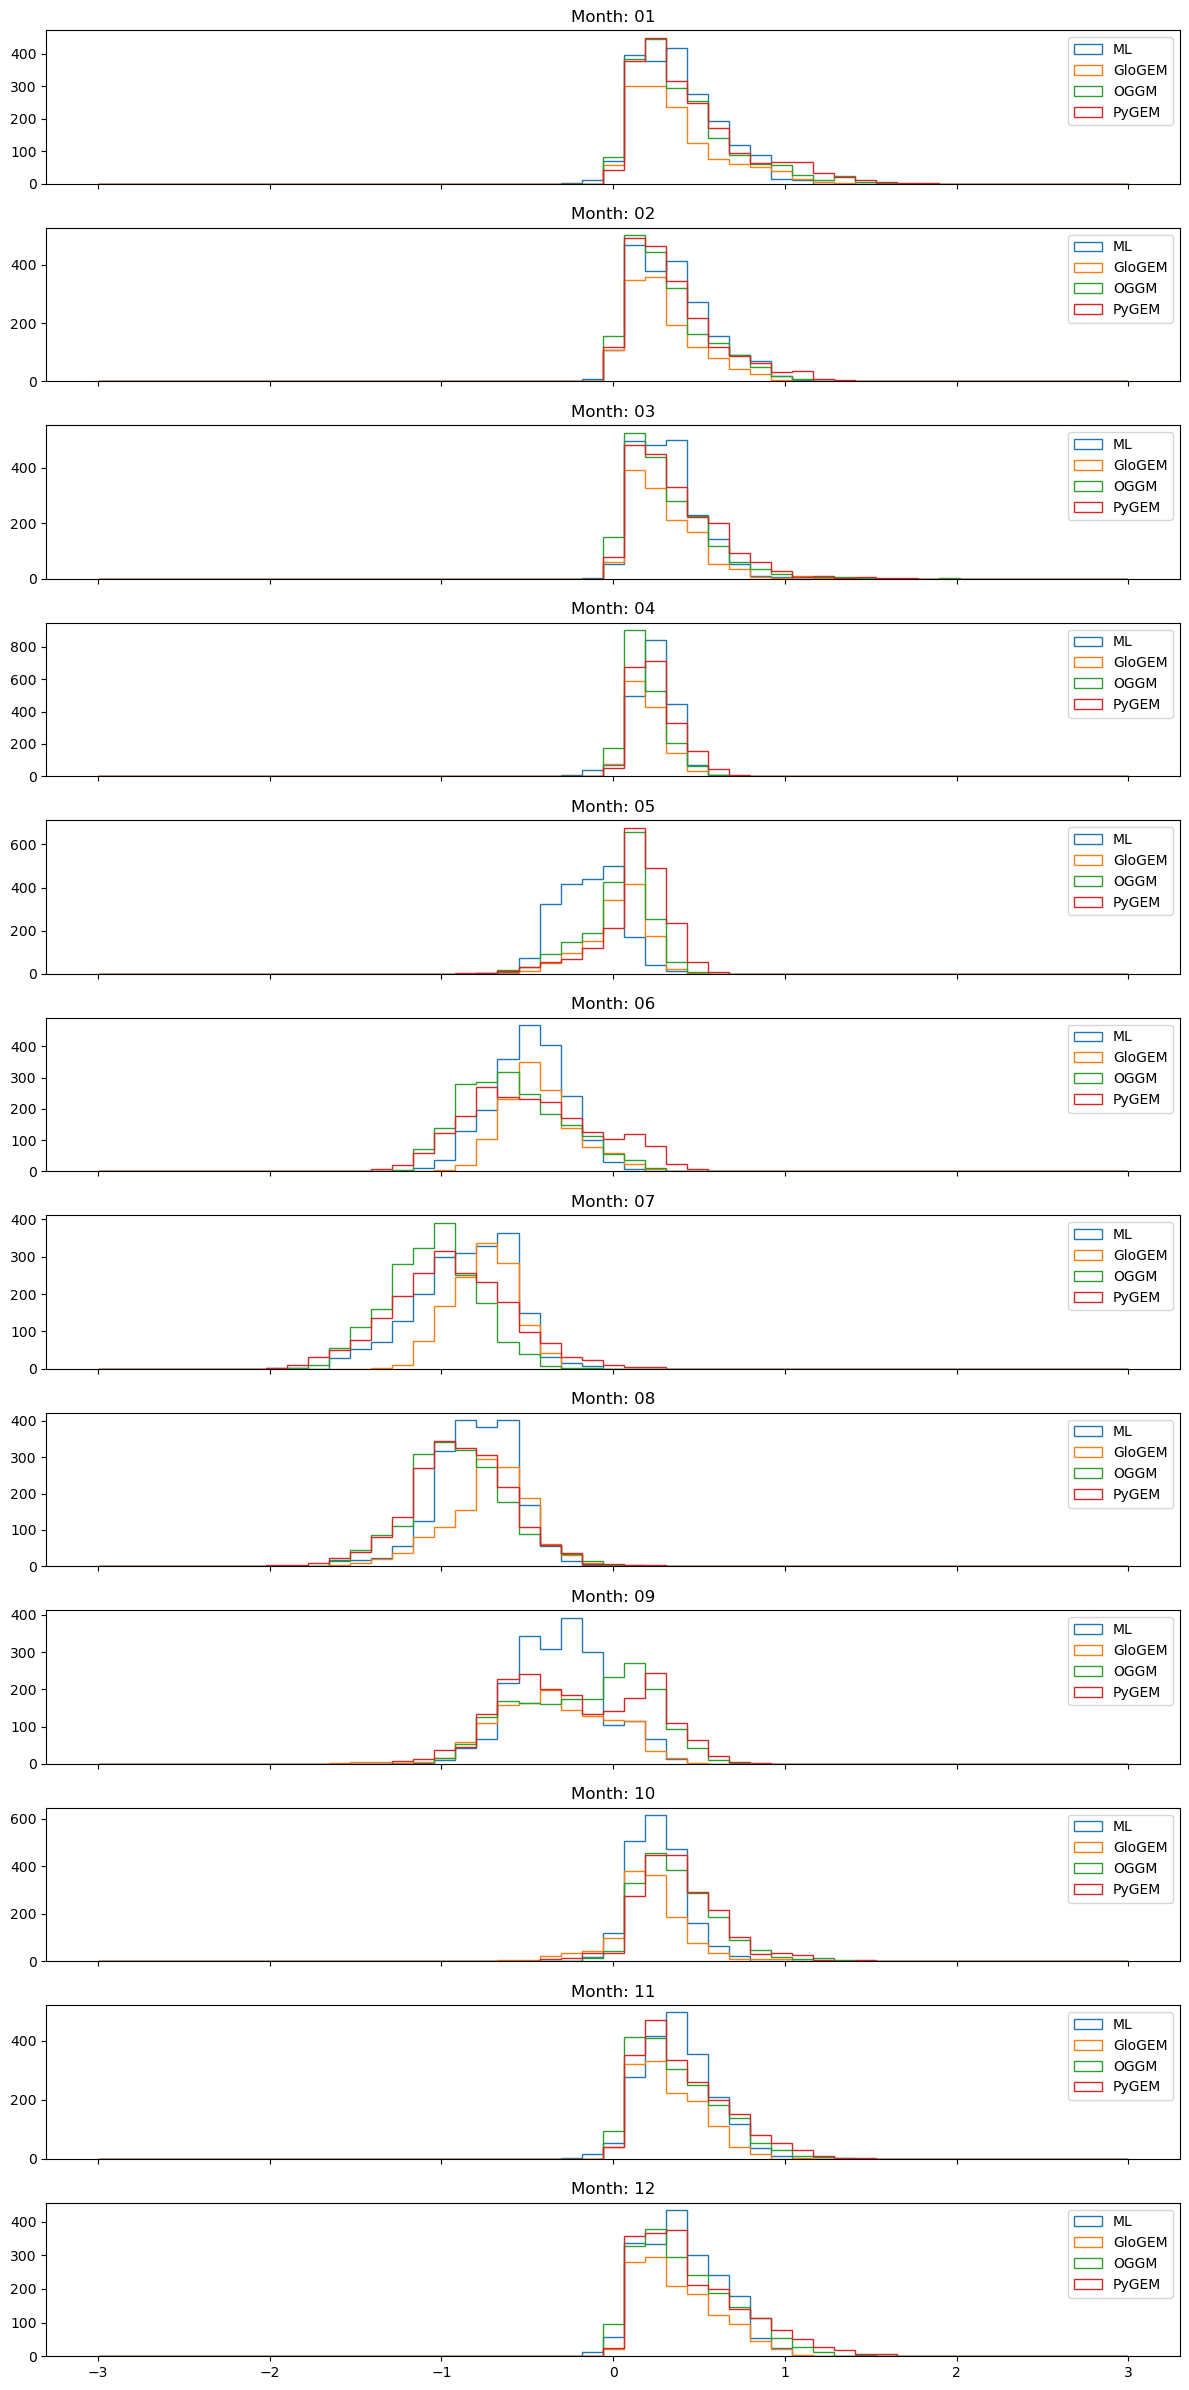

In [13]:
# plot test_pred and use X_test to get months
month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

fig, axes = plt.subplots(nrows=12, ncols=1, figsize=(12, 24), sharex=True)

# List of datasets
datasets = [('ML', ds_ML), ('GloGEM', ds_GLOGEM), ('OGGM', ds_OGGM), ('PyGEM', ds_PYGEM)]
#datasets = [('GloGEM', ds_GLOGEM), ('OGGM', ds_OGGM), ('PyGEM', ds_PYGEM)]

bins = np.linspace(-3, 3, 50) 

for i, ax in enumerate(axes.flatten()):
    month = i + 1
    
    # Histograms for datasets
    for label, ds in datasets:
        data = ds['mb_monthly'].sel(time=ds['time.month'] == month).values.flatten()
        data = data[~np.isnan(data)]
        ax.hist(data, bins=bins, label=label, histtype='step')

    ax.set_title(f'Month: {month:02d}')
    ax.legend()

plt.tight_layout()
plt.show()

## Plot glacier-wide monthly mass balances for common time period

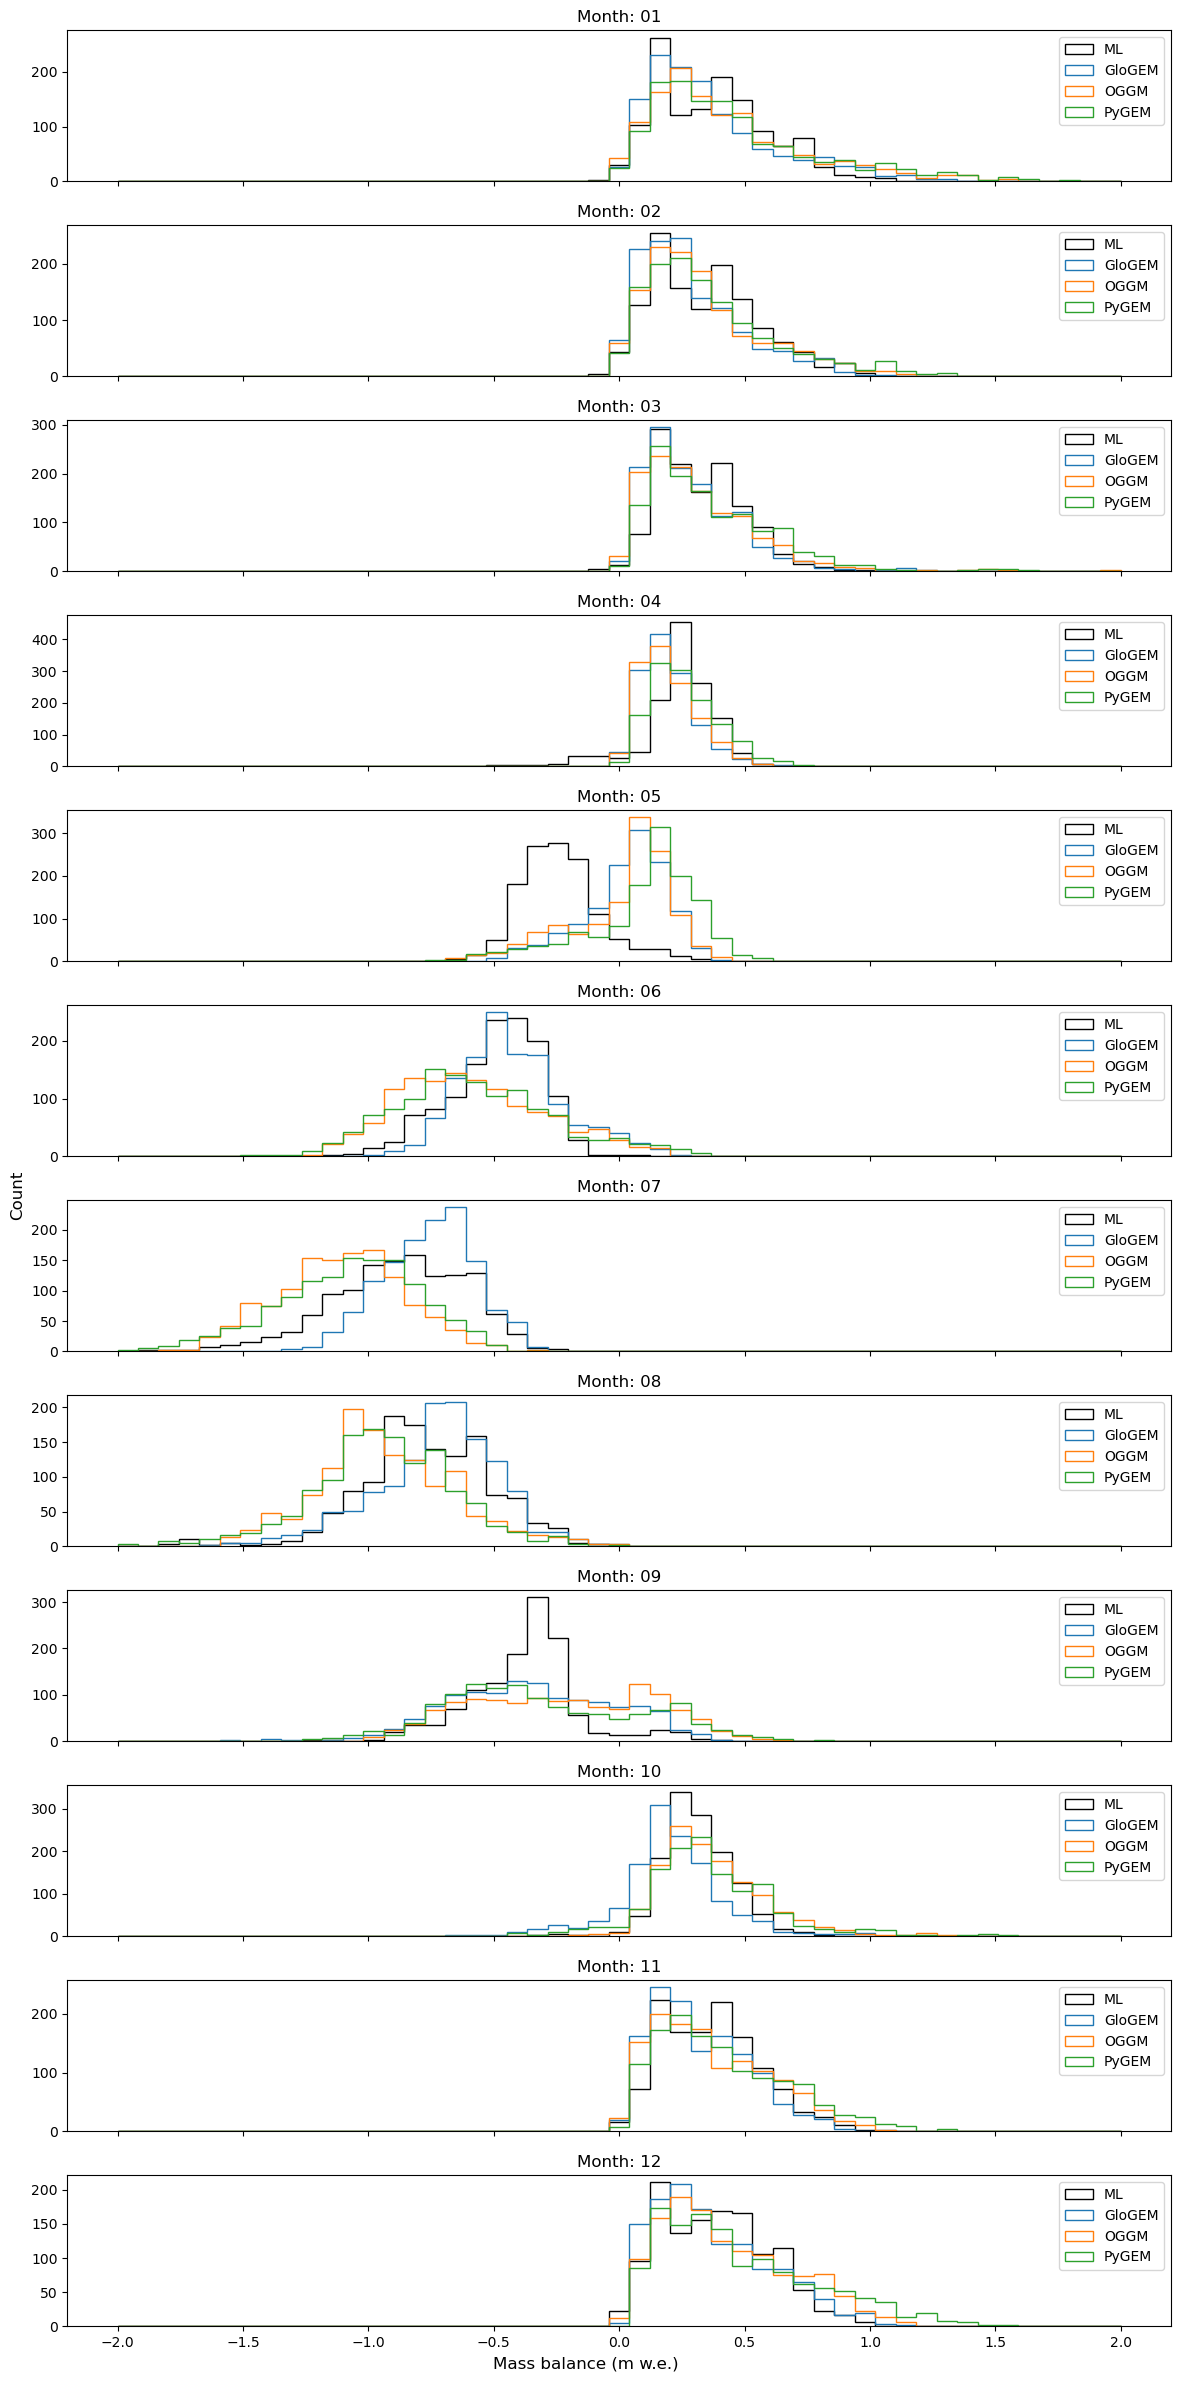

In [10]:
# Use time range from GloGEM: 1979-10-01 ... 2019-09-01
start = '1979-10-01'
end = '2019-09-01'
start_dt = pd.to_datetime(start).to_numpy()
end_dt = pd.to_datetime(end).to_numpy()

ds_ML_crop = ds_ML.sel(time=slice(start_dt, end_dt))
ds_OGGM_crop = ds_OGGM.sel(time=slice(start_dt, end_dt))
ds_PYGEM_crop = ds_PYGEM.sel(time=slice(start_dt, end_dt))
ds_GLOGEM_crop = ds_GLOGEM.sel(time=slice(start_dt, end_dt))

# plot test_pred and use X_test to get months
month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

fig, axes = plt.subplots(nrows=12, ncols=1, figsize=(12, 24), sharex=True)

# List of datasets
datasets = [('ML', ds_ML_crop, 'k'), ('GloGEM', ds_GLOGEM_crop, 'C0'), ('OGGM', ds_OGGM_crop, 'C1'), ('PyGEM', ds_PYGEM_crop, 'C2')]

bins = np.linspace(-2, 2, 50) 

for i, ax in enumerate(axes.flatten()):
    month = i + 1
    
    # Histograms for datasets
    for label, ds, color in datasets:
        data = ds['mb_monthly'].sel(time=ds['time.month'] == month).values.flatten()
        data = data[~np.isnan(data)]
        ax.hist(data, bins=bins, label=label, histtype='step', color=color)

    ax.set_title(f'Month: {month:02d}')
    ax.legend()

fig.supylabel('Count')
fig.supxlabel('Mass balance (m w.e.)')
plt.tight_layout()
plt.show()

<Figure size 1920x1440 with 0 Axes>

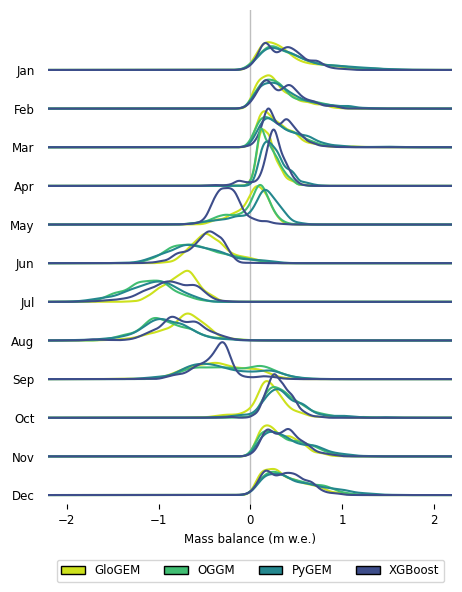

In [37]:
# Rigdeline plot

# Common period for all models
start = '1979-10-01'
end = '2019-09-01'
start_dt = pd.to_datetime(start).to_numpy()
end_dt = pd.to_datetime(end).to_numpy()

# Crop datasets to the specified time range
ds_ML_crop = ds_ML.sel(time=slice(start_dt, end_dt))
ds_OGGM_crop = ds_OGGM.sel(time=slice(start_dt, end_dt))
ds_PYGEM_crop = ds_PYGEM.sel(time=slice(start_dt, end_dt))
ds_GLOGEM_crop = ds_GLOGEM.sel(time=slice(start_dt, end_dt))

models = ['ML', 'GloGEM', 'OGGM', 'PyGEM']
datasets = [ds_ML_crop, ds_GLOGEM_crop, ds_OGGM_crop, ds_PYGEM_crop]

month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

cat_month = CategoricalDtype(month_order, ordered=True)

data = []

for i, month in enumerate(month_order, start=1):
    monthly_data = {'Month': month}
    for label, ds in zip(models, datasets):
        mass_balance_key = f'mb_{label.lower()}'
        monthly_values = ds['mb_monthly'].sel(time=ds['time.month'] == i).values.flatten()
        monthly_values = monthly_values[~np.isnan(monthly_values)]
        monthly_data[mass_balance_key] = monthly_values
    data.append(monthly_data)

dataframes = []

for month_data in data:
    month = month_data.pop('Month')
    max_len = max(len(v) for v in month_data.values())
    month_df = pd.DataFrame({k: np.pad(v, (0, max_len - len(v)), 'constant', constant_values=np.nan)
                             for k, v in month_data.items()})
    month_df['Month'] = month
    dataframes.append(month_df)

combined_df = pd.concat(dataframes)
combined_df['Month'] = combined_df['Month'].astype(cat_month)

# Define colors for each model
#model_colors = sns.color_palette('crest', 4).as_hex() # Blue hues
model_colors = sns.color_palette("colorblind", 4)[::-1] # Same as decadal plot
#model_colors1 = sns.color_palette('crest', 3).as_hex() # Blue hues
#model_colors2 = sns.color_palette("colorblind", 1).as_hex()#[1]#[::-1] # Same as decadal plot
#model_colors = model_colors2 + model_colors1
#model_colors = sns.color_palette("viridis_r",8)[::2]
model_colors = sns.color_palette("viridis_r",12)[0:11:3]

alpha = 1

cm = 1/2.54

plt.figure(dpi=300)

ax, fig = joypy.joyplot(
    data=combined_df[['Month','mb_ml','mb_glogem', 'mb_oggm', 'mb_pygem']],
    by='Month',
    column=['mb_glogem', 'mb_oggm','mb_pygem', 'mb_ml'],
    overlap=0.5,
    color=model_colors,
    fill = False,
    alpha=alpha,
    linewidth=1.5,
    #linecolor='k',
    #kind='values',
    figsize=(12*cm, 14*cm),
    xlabelsize = 8.5,
    ylabelsize = 8.5,
    x_range = [-2.2,2.2],
    grid = False
)

vline_alpha = 0.5 
plt.axvline(x=0, color='grey', alpha=vline_alpha, linewidth=1)

plt.xlabel('Mass balance (m w.e.)', fontsize=8.5)
plt.yticks(ticks=range(1, 13), labels=month_order, fontsize=8.5)
plt.gca().set_yticklabels(month_order)

legend_patches = [Patch(facecolor=color, label=model, alpha=alpha, edgecolor='k') for model, color in zip(['GloGEM', 'OGGM', 'PyGEM', 'XGBoost'], model_colors)]
plt.legend(handles=legend_patches, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4, fontsize=8.5)

#pdf_path = 'C:/Users/kasj/OneDrive - Høgskulen på Vestlandet/Projects/2022_ML_for_MB_Norway/Figures_paper/'
#plt.savefig(pdf_path+'comparison_glacier_wide_monthly_common_obs_nofill.pdf', format='pdf', bbox_inches='tight')

plt.show()


In [35]:
model_colors = sns.color_palette("viridis_r",12)[0:11:3]
model_colors

[(0.804182, 0.882046, 0.114965),
 (0.252899, 0.742211, 0.448284),
 (0.140536, 0.530132, 0.555659),
 (0.239346, 0.300855, 0.540844)]

In [19]:
model_colors1

['#61aa90', '#33858d', '#1e5d86']

In [10]:
combined_df


,mb_ml,mb_glogem,mb_oggm,mb_pygem,Month
0,0.361993,0.2930,0.431359,0.340340,Jan
1,0.575837,0.7604,0.997290,0.883464,Jan
2,0.478355,0.3671,0.449458,0.426519,Jan
3,0.436709,0.4210,0.585038,0.489194,Jan
4,0.315196,0.2716,0.376233,0.315744,Jan
...,...,...,...,...,...
1275,0.675995,0.6475,0.744635,0.867906,Dec
1276,0.633517,0.9964,0.921545,1.276796,Dec
1277,0.762833,0.7661,0.478551,0.959282,Dec
1278,0.712141,0.6984,0.732688,0.922468,Dec


In [13]:
40*32*12


15360